# 1.0 Introduction to JAX
Main references:
- [1] https://github.com/google/jax

- [2] https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/

- [3] https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
- [4] https://colinraffel.com/blog/you-don-t-know-jax.html
- [5] https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html


*At its core, JAX is an extensible system for transforming numerical functions.* JAX implements an updated version of **autograd**. Autograd's `grad` function takes in a **scalar** function, and returns to you the gradient function. 

 In this tutorial we will go through some of the main features included in the JAX package: ```grad``` and ```jit```.

 One of the main features you will probably use during this course is the ```grad``` function for computing gradients of your loss functions with respect to your model's weights.


## 1.1 Step-by-step example on how to use ```jax.grad``` for auto-differentiation.

**1) Define your function**

$$y = \sigma(wx + b),\ \sigma(x)=\frac{1}{1+e^{-x}}$$

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap, random, value_and_grad
import itertools
import time


key = random.PRNGKey(1)

x = random.normal(key)
w = random.normal(key+1)
b = random.normal(key+2)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

# 
def make_linear_sigmoid(x): 
  def predict(W, b): # Here, you define the function with the parameters that define your model
    return sigmoid(np.dot(x, W) + b)
  return predict 

## **2) Define your gradient with respect to the fitting weights**


The function `grad` takes as arguments:
-  `fun`: the numpy **function** for which the computation of the gradients is needed.
- `argnums`: the **arguments** of the functions  with respect to which the function will be differentiated

```
grad_not_jit(fun = make_linear_sigmoid(x),
                              argnums =  (0,1))

```
Returns the evaluated **gradients**.



---
**Quick quiz**: what would you change in the code above if you needed to differentiate the function only with respect to $b$?
a: argnums=(1)

**Using jit to speed up functions (VERY IMPORTANT FOR THE FUTURE)**

JAX provides jit (just in time compiler) which takes Python (using numpy) functions and compiles them such that they can be run efficiently on the chosen accelerators (CPU/GPU/TPU). Using jit could significantly speed up your computations and it requires little to no overhead in your coding. Let's have a look at a simple example. It is sufficient to use the jit decorator in front of your function such that the declared operation are compiled in advance (only once) and the code will run much more efficiently without any interpreter overhead.

In [ ]:
# I am ignoring the values returned for timing because of issues with the scoping of functions (timeit issue)
grad_not_jit = grad(make_linear_sigmoid(x), (0,1))
%timeit _, _ = grad_not_jit(w,b) # AUTOGRAD

grad_jit = jit(grad(make_linear_sigmoid(x), (0,1)))
%timeit _, _ = grad_jit(w,b) # AUTOGRAD

# Check with the analytical computation
w_gradient , b_gradient = grad_jit(w,b) # AUTOGRAD

w_gradient_manual = sigmoid(np.dot(x, w) + b) * (1 - sigmoid(np.dot(x, w) + b)) * x
b_gradient_manual = sigmoid(np.dot(x, w) + b) * (1 - sigmoid(np.dot(x, w) + b)) 

print()
print('Autograd result : w')
print(w_gradient)
print('Manually derived result : w')
print(w_gradient_manual)

print('Autograd result : b')
print(b_gradient)
print('Manually derived result : b')
print(b_gradient_manual)

The slowest run took 79.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 5.73 ms per loop
The slowest run took 1772.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 71.6 µs per loop

Autograd result : w
-0.26804116
Manually derived result : w
-0.2680411
Autograd result : b
0.22633177
Manually derived result : b
0.22633173


#2.0 Review of Linear Regression
As studied in your lecture, in linear regression, we are given a data set $\mathcal{D} =  \{(x_n,t_n)\}_{n=1}^N$, where $x_n = \mathbb{R}^d$, where $d \geq 1$ represents the dimension of your data,  and $t_n \in \mathbb{R}$ which are the target values that each data $x_n$ corresponds to. 

Next, we seek a prediction function $y$ that takes in $x_n$ and outputs a prediction vector,
$$
  y(x) = \textstyle\sum\limits_{i = 1}^d w_i x_i + b.
$$  

Let the squared loss be defined as,
\begin{equation}
	\mathcal{L}(x,t) = \dfrac{1}{2}(y(x) - t)^2, t \in \mathbb{R} 
\end{equation}
We can then the optimal prediction function by minimizing the mean squared error,
\begin{equation}
		\mathcal{E}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N \mathcal{L}(x_n, t_n) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2 \tag*{(mse)}
\end{equation}

In the following code, you will generate a data set $\mathcal{D}$ consisting of $20$ 1D data points $x_n$ sampled from a uniform distribution along with targets $t_n$ assumed to be given by the formula,

$$
  t_n = \sin(\pi x_n) + 0.3*\epsilon, \epsilon \sim \mathcal{N}(0,1)
$$
Let us visualize these data point using the Matplotlib package. 

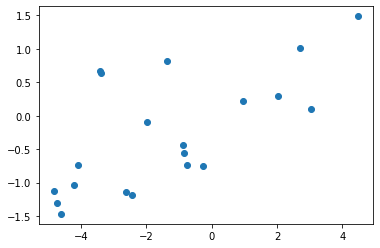

In [ ]:
n, d = 20, 1 #n represents data points and d represents the number of dimensions

x = random.uniform(key, (n, d), dtype=np.float64,  minval = -5., maxval = 5.)    
t = np.sin(np.pi*x) + 0.3*random.normal(key, (n, d))    

import matplotlib.pyplot as plt

plt.scatter(x, t)
plt.show()

## 2.1 Directly Solving for $w^\star$ Using the Normal Equation

Since our data set is small, therefore we can directly find the optimal predictor using a bit of linear algebra.

To account for the bias term, it is common to redefining our data and weight as $x_n := \begin{bmatrix} 1 & x_n^\top \end{bmatrix}$ and $w := \begin{bmatrix} b & w^\top \end{bmatrix}$, 
$$
  y(x_n) = \textstyle\sum\limits_{i = 1}^{d+1} w_i x_{n_i} = w^\top x_n.
$$

Then, we can show that our mean squared error can be equivalently written as $$\mathcal{E}(w) =    \dfrac{1}{2N} \|Xw-t\|^2_2,$$
where \begin{equation}
X = \begin{bmatrix} x_1^\top \\ \vdots \\ x_N^\top \end{bmatrix}  \in \mathbb{R}^{N \times (d+1)} \quad \text{and} \quad t = \begin{bmatrix} t_1\\ \vdots \\ t_N \end{bmatrix} \in \mathbb{R}^N
\end{equation}

It can be shown that, $$w^\star = (X^\top X)^{-1}X^\top t$$ minimizes the mean-squared error $\mathcal{E}$. This expression is sometimes referred to as the *normal equation*. 

**In the space below, build the matrix $X$ and find the optimal solution $w^\star$. Afterwards, plot the optimal prediction function against your dataset.**


[[0.8563728]
 [1.9547423]
 [2.9778275]
 [4.0255833]]


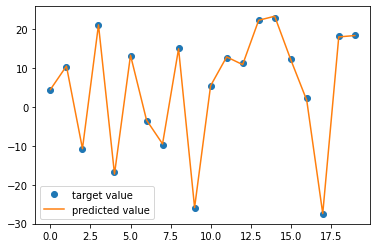

In [ ]:
#Bult the X matrix here
X = random.uniform(key, (20, 3), dtype=np.float64,  minval = -5., maxval = 5.)  
b = np.ones((20,1))

X = np.concatenate((b,X),axis=1)
tar = np.dot(X,np.array([[1,2,3,4]]).T)+ 0.3*random.normal(key, (20, 1)) 
#Compute w using the normal equation
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),tar)
print(w)
#Write your optimal predictor here
y = np.dot(X,w) 

#Plot your prediction against data points
index=np.arange(20)
plt.plot(index,tar,"o",index,y,"-")
plt.legend(loc='lower left', labels=['target value', 'predicted value'])
plt.show()

## 2.2 Find $w^\star$ Using Gradient Descent

Next, you will use gradient descent to find the solution to the linear regression problem. Recall that the update equation for gradient descent (as studied in class) is given by,

$$w_{k+1} = w_k - \alpha \nabla \mathcal{E}(w_k)$$

$\alpha$ is our learning rate which is usually a small number, e.g., $0.1$

**Implement a jax routine for calculating the gradient of $\mathcal{E}$, and then run the gradient descent algorithm (say, for 100 iterations) until the optimal weight is found.** 

### 2.2.1 **Define the mse function**

Hint: your code could be similar to how we built the logistic function at the beginning

In [ ]:
# Build the mse function here
from scipy.special import expit as sigmoid
import math
def forward(X,tar):
  def params(w):
    return np.sum((np.dot(X,w)-tar)*(np.dot(X,w)-tar)*0.5)/len(x)
  return params

### 2.2.2 **Implement Gradient Descent and Run for (say, 100) Interations**


$$w_{k+1} = w_k - \alpha \nabla \mathcal{E}(w_k)$$

Hint: The function `grad` takes as arguments:
-  `fun`: the numpy **function** for which the computation of the gradients is needed.
- `argnums`: the **arguments** of the functions  with respect to which the function will be differentiated

Example:
```
w_gradient, b_gradient = grad(fun = make_mse(x, t), argnums = (0,1))(w,b) 
```

Then use calculated the gradient in your gradient descent update in a FOR loop
.

In [ ]:
alpha = 0.1
iterations = 100

# Update w, b by calculating the gradient and making the update. 
GDnotjit = grad(forward(X,tar), (0))
w_initial = random.uniform(key, (4, 1), dtype=np.float64)
print(w_initial)
for i in range(iterations):
  w_gradient = GDnotjit(w_initial)
  w_initial-=alpha*w_gradient
  loss=np.sum((np.dot(X,w_initial)-tar)*(np.dot(X,w_initial)-tar)*0.5)/len(x)
  if i%10==0:
    print("w: ",w_initial,loss)
w_optimal=w_initial

[[0.5685525 ]
 [0.322456  ]
 [0.8893297 ]
 [0.47169125]]
w:  [[0.9298066]
 [2.6671119]
 [2.8518972]
 [2.8518085]] 5.118276
w:  [[0.94474745]
 [1.9543501 ]
 [2.9758232 ]
 [4.0129395 ]] 0.03208787
w:  [[0.8909025]
 [1.9544897]
 [2.9770794]
 [4.020877 ]] 0.029052904
w:  [[0.8698519]
 [1.9546436]
 [2.9775355]
 [4.023746 ]] 0.028590614
w:  [[0.8616343]
 [1.9547036]
 [2.9777133]
 [4.0248656]] 0.02852014
w:  [[0.85842645]
 [1.9547272 ]
 [2.9777827 ]
 [4.025303  ]] 0.028509308
w:  [[0.85717416]
 [1.9547361 ]
 [2.97781   ]
 [4.0254736 ]] 0.0285077
w:  [[0.85668534]
 [1.9547399 ]
 [2.9778206 ]
 [4.0255404 ]] 0.028507465
w:  [[0.8564945]
 [1.9547412]
 [2.9778247]
 [4.0255666]] 0.02850744
w:  [[0.85642004]
 [1.9547417 ]
 [2.977826  ]
 [4.0255766 ]] 0.028507425


### 2.2.3 **Build your optimal linear prediction function and visualize your fit to the data**


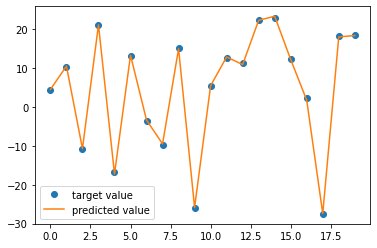

In [ ]:
# Your optimal linear prediction function here
Y=np.dot(X,w_optimal)


# Visualize your data and your fit
plt.plot(index,tar,"o",index,Y,"-")
plt.legend(loc='lower left', labels=['target value', 'predicted value'])
plt.show()

### 2.2.4 **(Optional) You can use jit to speed calculation.** 

**Repeat the gradient descent procedure as before but using jit to speed up the calculation of gradients.**

In [ ]:
# Build your jitted gradient descent iteration here

#3.0 Overfitting and Regularization

The goal of supervised machine learning is to make accurate predictions on data that are not from the training set, also known as the *test set*. However it is not guaranteed that the more data we train on, the better we will perform on the test set. 

It could happen that we fit our training set too well, so that a test data that does not look like the training data will cause a large error in our prediction. This is called **overfitting**: the scenario when a predictor that achieves a lower error on the training set results in a large error on the test set.

To overcome overfitting, we can use a technique called regularization, which involves adding a function on to our mean squared error. In the following examples, we will step through several examples of regularization techniques. 

## 3.1 Building a Dataset

The code below creates a data set of  $n = 100$ examples generated from uniformly from $[-5, 5]$, each example is $5$ dimensional. The targets are assigned as follows, $$t  = x^\top \overline w + 0.1 * \epsilon, \epsilon \sim \mathcal{N}(0,1)$$ 
where $\overline w$ is a randomly generated vector with normal distribution. 


**Your first task is to partition the data into 50 test examples, 20 validation examples and 30 test examples.** 

In [ ]:
d = 5                             #dimension of your data
n = 100                           #total number of data points
n_train = 50                      #total number of training examples
n_validate = 20                   #total number of examples for validation 
n_test = 30                       #total number of examples for testing

x_data = random.uniform(key, (n, d), dtype=np.float64,  minval = -5., maxval = 5.)    
true_w = random.normal(key, (d,))
t_data = x_data.dot(true_w) + 0.1 * random.normal(key, (n,))

#Partition into training, validation and test set
x_train = x_data[:50]
x_val = x_data[50:70]
x_test = x_data[70:100]

t_train = t_data[:50]
t_val = t_data[50:70]
t_test = t_data[70:100]
print(x_data)

[[ 1.4137816   1.430788    4.0541945  -1.2773418  -2.0266628 ]
 [ 3.9236727  -0.32455206  1.3953028   1.1383653   3.1143055 ]
 [-2.741723    3.9734507   4.302367    2.4208593  -3.4558427 ]
 [-1.6669703   1.456387    2.1204448   0.9421692  -1.5382063 ]
 [-1.3605666  -3.4809303  -4.8397684  -3.6949873  -0.31685734]
 [-0.6236706  -3.5205686  -3.5384655  -2.0179164  -3.8888943 ]
 [-3.9208055  -4.327141   -4.348073    3.2808914   0.58691025]
 [-2.7467191   2.238573    0.48922634  1.2298145   1.9059467 ]
 [-1.4907634   1.0580468  -1.8860197   0.24154425 -4.4085083 ]
 [-4.908631    0.98646736 -3.404014    2.3044405   4.449663  ]
 [ 0.02124786  3.9214525  -0.23204088  0.77283955 -0.27360058]
 [ 3.4294024  -3.520472   -1.5473902  -3.1539404  -2.9430747 ]
 [ 2.602532   -2.0462      0.27842522 -0.20933056  0.6970539 ]
 [-1.9941795   1.4481997  -3.3872437  -3.4926784  -0.1673994 ]
 [ 0.934535   -3.1480074   3.0547314   4.672592   -3.7734222 ]
 [-1.6803193   1.8864164  -0.8594656   2.666738   -1.98

## 3.2 Solve for $w^\star$ Using Gradient Descent

Next, using the same linear regresion code that you have built above, using gradient descent, compute the optimal predictor $y = x^\top w^\star + b^\star$ corresponding to the mean-squared error 
$$\mathcal{E}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2$$ 

Afterwards, find the error between the predicted targets on the test set versus the true test targets using the formula,
$$\|y_\text{test}- t_\text{test}\|_2$$
where $y_\text{test}$ is your prediction on the test set. 

In [ ]:
#Define your mse function here 
def mse(x,t):
  def error(w):
    return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)
  return error
#Perform gradient descent
learningrate = 0.01
iterations = 100
 
GD = grad(mse(x_train,t_train), (0))
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for i in range(iterations):
  w_gradient = GD(w_initial)
  w_initial-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_initial)-t_train)*(np.dot(x_train,w_initial)-t_train)*0.5)/len(x_train)
  if i%10==0:
    print("w: ",w_initial,aggerr)

loss=np.sum((np.dot(x_val,w_initial)-t_val)*(np.dot(x_val,w_initial)-t_val)*0.5)/len(x_val)
if loss>aggerr:
  print("validation fails",loss)
else:
  print("validation completed")

w_optimal=w_initial

#Compute and print your test error
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
w:  [0.8370034  0.04520406 0.37929025 0.58540785 0.567572  ] 7.6980267
w:  [ 0.8798487  -0.6006399  -0.00203413  0.33893847  0.46062616] 0.86957777
w:  [ 0.90798855 -0.8076084  -0.09354074  0.31384078  0.3444836 ] 0.18406372
w:  [ 0.92749095 -0.88839495 -0.11519028  0.3261901   0.27063826] 0.052927516
w:  [ 0.94010526 -0.9254346  -0.12025023  0.33969313  0.2289996 ] 0.01812475
w:  [ 0.94784355 -0.9441278  -0.12151283  0.34910834  0.20641069] 0.008023058
w:  [ 0.9524578  -0.9540061  -0.12195915  0.35500154  0.19430926] 0.005020983
w:  [ 0.9551798  -0.959324   -0.12223489  0.35855085  0.18784556] 0.0041198614
w:  [ 0.956787   -0.9622016  -0.12245855  0.36065286  0.1843903 ] 0.0038472917
w:  [ 0.9577443  -0.96375597 -0.12264467  0.36188662  0.1825386 ] 0.0037641686
validation fails 0.004698316
0.6157995383221567


## 3.3 $l_2$ regularization

The first regularization technique we will introduce is called $l_2$ regularization. 

We define our mean-squared loss function as
$$\mathcal{E}_{l_2}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2 + \dfrac{\lambda_2}{2}\|w\|^2_2$$
where $\lambda_2$ is a small positive constant we refer to as the regularization constant, e.g., $r = 0.01$. 

This optimization problem is called *ridge regression*. 

Make slight changes to your previous code to account for the $l_2$ norm, and using gradient descent, compute the optimal predictor $y = x^\top w^\star + b^\star$ corresponding to this regularized mean-squared error.

In [ ]:
#Define your mse function here 
def mse(x,t):
  def error(w,r):
    return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r*0.5*np.sum(w*w)
  return error 

#Perform gradient descent
learningrate = 0.01
iterations = 100
r=0.01 
GD = grad(mse(x_train,t_train), (0))
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for i in range(iterations):
  w_gradient = GD(w_initial,r)
  w_initial-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_initial)-t_train)*(np.dot(x_train,w_initial)-t_train)*0.5)/len(x_train)+r*0.5*np.sum(w_initial*w_initial)
  if i%10==0:
    print("w: ",w_initial,aggerr)

loss=np.sum((np.dot(x_val,w_initial)-t_val)*(np.dot(x_val,w_initial)-t_val)*0.5)/len(x_val)+r*0.5*np.sum(w_initial*w_initial)
if loss>aggerr:
  print("validation fails",loss,loss-aggerr)
else:
  print("validation completed")

w_optimal=w_initial

#Compute and print your test error
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
w:  [0.8369203  0.04518746 0.37924463 0.58534354 0.56751513] 7.704812
w:  [ 0.8792205  -0.6004217  -0.00204661  0.33854747  0.46025792] 0.8769959
w:  [ 0.9070743  -0.80709803 -0.09335087  0.31326294  0.34413075] 0.19315135
w:  [ 0.9263899  -0.8876985  -0.11485956  0.32545838  0.27040595] 0.06266121
w:  [ 0.9388703  -0.9246258  -0.11983083  0.3388452   0.2288896 ] 0.028115332
w:  [ 0.94651115 -0.94325143 -0.12103494  0.34817934  0.2063957 ] 0.01811276
w:  [ 0.951055   -0.95309    -0.12144034  0.35401845  0.19436076] 0.015147542
w:  [ 0.9537263  -0.9583855  -0.12168634  0.35753253  0.18794124] 0.014259808
w:  [ 0.95529735 -0.9612515  -0.12188791  0.359612    0.18451455] 0.013992036
w:  [ 0.9562286  -0.9628006  -0.12205748  0.36083144  0.18268101] 0.01391064
validation fails 0.014787367 0.0009003151
0.617477831577725


### 3.3.1 Hyperparameter Tuning Using Validation Set

Next, you are going to tune the regularization parameter $\lambda_2$ using your validation set. 

Train several different models for $\lambda_2 \in \{0.1, 0.01, 0.001\}$. Then compute the error between your prediction on the validation set and the corresponding targets using the formula,
$$\|y_\text{val}- t_\text{val}\|_2$$

Pick the best performing model.

In [ ]:
#Your code Here
r=np.array([0.1,0.01,0.001])
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for k in range(len(r)):
  w_exe=w_initial
  def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r[k]*0.5*np.sum(w*w)
    return error 
  GD = grad(mse(x_train,t_train), (0))
  for i in range(iterations):
    w_gradient = GD(w_exe,r)
    w_exe-=learningrate*w_gradient
    aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.5)/len(x_train)+r[k]*0.5*np.sum(w_exe*w_exe)
    if i%10==0:
      print("iteration: ",i,"loss: ",aggerr)
  print("learning done")
  y_val=x_val.dot(w_exe)
  valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
  print("validaiton error: ",valerr)
#pick the best performing model
r=0.01


[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
iteration:  0 loss:  7.765745
iteration:  10 loss:  0.9431494
iteration:  20 loss:  0.27403587
iteration:  30 loss:  0.14918116
iteration:  40 loss:  0.1168496
iteration:  50 loss:  0.10769016
iteration:  60 loss:  0.10503388
iteration:  70 loss:  0.10425641
iteration:  80 loss:  0.10402739
iteration:  90 loss:  0.10395959
learning done
validaiton error:  0.48931104785383583
iteration:  0 loss:  7.704812
iteration:  10 loss:  0.8769959
iteration:  20 loss:  0.19315135
iteration:  30 loss:  0.06266121
iteration:  40 loss:  0.028115332
iteration:  50 loss:  0.01811276
iteration:  60 loss:  0.015147542
iteration:  70 loss:  0.014259808
iteration:  80 loss:  0.013992036
iteration:  90 loss:  0.01391064
learning done
validaiton error:  0.4324355766792823
iteration:  0 loss:  7.698706
iteration:  10 loss:  0.8703203
iteration:  20 loss:  0.18497333
iteration:  30 loss:  0.05390199
iteration:  40 loss:  0.019125013
iteration:  50 loss: 

### 3.3.2 Compute Test Error

Finally, using the best performing model, find the error between the predicted targets on the test set versus the true test targets using the formula,
$$\|y_\text{test}- t_\text{test}\|_2$$
where $y_\text{test}$ is your prediction on the test set. 

In [ ]:
# Your code Here
#Define your mse function here 
def mse(x,t):
  def error(w,r):
    return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r*0.5*np.sum(w*w)
  return error 

#Perform gradient descent
learningrate = 0.01
iterations = 100
r=0.001 
GD = grad(mse(x_train,t_train), (0))
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for i in range(iterations):
  w_gradient = GD(w_initial,r)
  w_initial-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_initial)-t_train)*(np.dot(x_train,w_initial)-t_train)*0.5)/len(x_train)+r*0.5*np.sum(w_initial*w_initial)
  if i%10==0:
    print("iteration: ",i,"loss: ",aggerr)
w_optimal=w_initial

#Compute and print your test error
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
iteration:  0 loss:  7.698706
iteration:  10 loss:  0.8703203
iteration:  20 loss:  0.18497333
iteration:  30 loss:  0.05390199
iteration:  40 loss:  0.019125013
iteration:  50 loss:  0.009033271
iteration:  60 loss:  0.006034908
iteration:  70 loss:  0.0051351422
iteration:  80 loss:  0.004863055
iteration:  90 loss:  0.0047801062
0.6159172264954724


## 3.4 $l_1$ Regularization 

The next regularization technique we will introduce is called $l_1$ regularization. 

We define our mean-squared loss function as 
$$\mathcal{E}_{l_1}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2 + \dfrac{\lambda_1}{2}\|w\|_1$$
where $\lambda_1$ is again our regularization constant.

This optimization problem is called the *LASSO*. 

**Repeat the previous experiment by training several different models and choosing the best one based on its performance on the validation set.** 

**Finally, pick the best performing model and use it to find the error between the predicted targets on the test set versus the true test targets.**

In [ ]:
# Your code here
r=np.array([0.1,0.01,0.001])
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for k in range(len(r)):
  w_exe=w_initial
  def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r[k]*0.5*np.linalg.norm(w,1)
    return error 
  GD = grad(mse(x_train,t_train), (0))
  for i in range(iterations):
    w_gradient = GD(w_exe,r)
    w_exe-=learningrate*w_gradient
    aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.5)/len(x_train)+r[k]*0.5*np.linalg.norm(w_exe,1)
    if i%10==0:
      print("iteration: ",i,"loss: ",aggerr)
  print("learning done")
  y_val=x_val.dot(w_exe)
  valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
  print("validaiton error: ",valerr)
#pick the best performing model
r=0.001
#Compute and print your test error
w_exe=w_initial
def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r*0.5*np.linalg.norm(w,1)
    return error 
GD = grad(mse(x_train,t_train), (0))
for i in range(iterations):
  w_gradient = GD(w_exe,r)
  w_exe-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.5)/len(x_train)+r*0.5*np.linalg.norm(w_exe,1)
  if i%10==0:
    print("iteration: ",i,"loss: ",aggerr)
print("learning done")
y_val=x_val.dot(w_exe)
valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
print("validaiton error: ",valerr)
w_optimal=w_exe
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
iteration:  0 loss:  7.8076334
iteration:  10 loss:  0.98115426
iteration:  20 loss:  0.31005502
iteration:  30 loss:  0.1807274
iteration:  40 loss:  0.14640722
iteration:  50 loss:  0.13647585
iteration:  60 loss:  0.1335365
iteration:  70 loss:  0.13265863
iteration:  80 loss:  0.13239479
iteration:  90 loss:  0.13231508
learning done
validaiton error:  0.5133296566321661
iteration:  0 loss:  7.7089987
iteration:  10 loss:  0.88076234
iteration:  20 loss:  0.19673368
iteration:  30 loss:  0.06579132
iteration:  40 loss:  0.031042036
iteration:  50 loss:  0.020959847
iteration:  60 loss:  0.017965302
iteration:  70 loss:  0.017067164
iteration:  80 loss:  0.016795821
iteration:  90 loss:  0.016713232
learning done
validaiton error:  0.4342800242377959
iteration:  0 loss:  7.6991234
iteration:  10 loss:  0.8706964
iteration:  20 loss:  0.18533157
iteration:  30 loss:  0.054214805
iteration:  40 loss:  0.01941742
iteration:  50 l

## 3.5 Approximate $l_1$ Regularization

A technicality is that the  $l_1$ norm is not differentiable, so JAX was actually avoiding the non-differentiable points.

To address the non-differentiability of $l_1$ norm, Schmidt *et al.* [1] proposed a differentiable approximation to the $l_1$ norm.

In this case, we define our mean-squared loss function as 
$$\mathcal{E}_{\widetilde{l_1}}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2 + \sum\limits_{i = 1}^d \dfrac{\lambda}{a} (\log(1+\exp(a w_i)) + \log(1-\exp(-a w_i)))$$
where both $a$ and $\lambda$ are regularization constants.


**Repeat the previous experiments by training several different models and choosing the best one based on its performance on the validation set.** 

(For convenience, you can fix $a$, say $a = 0.1$. Alternatively you can tune both $a$ and $\lambda$)

**Finally, pick the best performing model and use it to find the error between the predicted targets on the test set versus the true test targets.**

[1] *Mark Schmidt, Glenn Fung, and Rmer Rosales. Fast
optimization methods for l1 regularization: A comparative study and two new approaches. In European Conference on Machine Learning, pages 286–297.
Springer, 2007.*

In [ ]:
# Your code here

r=np.array([0.1,0.01,0.001])
w_initial = random.uniform(key, (d,), dtype=np.float64)
learningrate=0.01

for k in range(len(r)):
  w_exe=w_initial
  def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+(r[k]/0.1)*np.sum(np.log(1+np.exp(0.1*w))+np.log(1+np.exp(-0.1*w)))
    return error 
  GD = grad(mse(x_train,t_train), (0))
  for i in range(iterations):
    w_gradient = GD(w_exe,r)
    w_exe-=learningrate*w_gradient
    aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.2)/len(x_train)+(r[k]/0.1)*np.sum(np.log(1+np.exp(0.1*w_exe))+np.log(1+np.exp(-0.1*w_exe)))
    if i%10==0:
      print("iteration: ",i,"loss: ",aggerr,"w",w_exe)
  print("learning done")
  y_val=x_val.dot(w_exe)
  valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
  print("validaiton error: ",valerr)
#pick the best performing model
r=0.01 
w_exe=w_initial
def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+(r/0.1)*np.sum(np.log(1+np.exp(0.1*w))+np.log(1+np.exp(-0.1*w)))
    return error 
GD = grad(mse(x_train,t_train), (0))
for i in range(iterations):
  w_gradient = GD(w_exe,r)
  w_exe-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.2)/len(x_train)+(r/0.1)*np.sum(np.log(1+np.exp(0.1*w_exe))+np.log(1+np.exp(-0.1*w_exe)))
  if i%10==0:
    print("iteration: ",i,"loss: ",aggerr)
print("learning done")
y_val=x_val.dot(w_exe)
valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
print("validaiton error: ",valerr)
w_optimal=w_exe
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

iteration:  0 loss:  10.014305 w [0.83696187 0.04519575 0.37926745 0.5853757  0.5675436 ]
iteration:  10 loss:  7.282977 w [ 0.87953466 -0.60053086 -0.00204039  0.33874297  0.46044198]
iteration:  20 loss:  7.009466 w [ 0.9075315  -0.8073534  -0.09344581  0.31355184  0.3443071 ]
iteration:  30 loss:  6.95735 w [ 0.9269405  -0.88804686 -0.11502488  0.32582417  0.27052194]
iteration:  40 loss:  6.9436 w [ 0.9394878  -0.92503035 -0.12004042  0.339269    0.22894448]
iteration:  50 loss:  6.939649 w [ 0.94717723 -0.9436899  -0.1212737   0.3486437   0.20640309]
iteration:  60 loss:  6.938495 w [ 0.95175624 -0.9535482  -0.1216995   0.35450977  0.19433494]
iteration:  70 loss:  6.9381604 w [ 0.95445293 -0.9588549  -0.12196036  0.35804144  0.18789338]
iteration:  80 loss:  6.9380655 w [ 0.956042   -0.9617267  -0.12217296  0.36013216  0.18445243]
iteration:  90 loss:  6.9380407 w [ 0.9569863  -0.9632784  -0.12235078  0.3613587   0.18260981]
learning done
validaiton error:  0.43277300230958643
it

## 3.6 Elastic Net

Finally, we can define our mean-squared loss function as a combination of $l_1$ and $l_2$ norm, 
$$\mathcal{E}_{l_1+l_2}(w) = \dfrac{1}{2N}\sum\limits_{n=1}^N (w^\top x_n + b - t_n)^2 + \frac{r_1}{2}\|w\|_1 + \dfrac{r_2}{2}\|w\|_2^2$$

This regularizer is called the elastic net. 

**Repeat the previous experiments by training several different models and choosing the best one based on its performance on the validation set.** 

**Finally, pick the best performing model and use it to find the error between the predicted targets on the test set versus the true test targets.**

In [ ]:
# Your code here: 
r=np.array([0.1,0.01,0.001])
w_initial = random.uniform(key, (d,), dtype=np.float64)
print(w_initial)
for k in range(len(r)):
  w_exe=w_initial
  def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r[k]*0.5*np.linalg.norm(w,1)+r[k]*0.5*np.sum(w*w)
    return error 
  GD = grad(mse(x_train,t_train), (0))
  for i in range(iterations):
    w_gradient = GD(w_exe,r)
    w_exe-=learningrate*w_gradient
    aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.5)/len(x_train)+r[k]*0.5*np.linalg.norm(w_exe,1)+r[k]*0.5*np.sum(w_exe*w_exe)
    if i%10==0:
      print("iteration: ",i,"loss: ",aggerr)
  print("learning done")
  y_val=x_val.dot(w_exe)
  valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
  print("validaiton error: ",valerr)
#pick the best performing model
r=0.001
w_exe=w_initial
def mse(x,t):
    def error(w,r):
      return np.sum((np.dot(x,w)-t)*(np.dot(x,w)-t)*0.5)/len(x)+r*0.5*np.linalg.norm(w,1)+r*0.5*np.sum(w*w)
    return error 
GD = grad(mse(x_train,t_train), (0))
for i in range(iterations):
  w_gradient = GD(w_exe,r)
  w_exe-=learningrate*w_gradient
  aggerr=np.sum((np.dot(x_train,w_exe)-t_train)*(np.dot(x_train,w_exe)-t_train)*0.5)/len(x_train)+r*0.5*np.linalg.norm(w_exe,1)+r*0.5*np.sum(w_exe*w_exe)
  if i%10==0:
    print("iteration: ",i,"loss: ",aggerr)
print("learning done")
y_val=x_val.dot(w_exe)
valerr=math.sqrt(np.sum((y_val-t_val)*(y_val-t_val)))
print("validaiton error: ",valerr)
w_optimal=w_exe
y_test=x_test.dot(w_optimal)
testerr=math.sqrt(np.sum((y_test-t_test)*(y_test-t_test)))
print(testerr)

[0.83079386 0.1660409  0.45611215 0.6428884  0.56865394]
iteration:  0 loss:  7.8751106
iteration:  10 loss:  1.0536957
iteration:  20 loss:  0.39844126
iteration:  30 loss:  0.27517712
iteration:  40 loss:  0.24323499
iteration:  50 loss:  0.23420286
iteration:  60 loss:  0.23158887
iteration:  70 loss:  0.23082466
iteration:  80 loss:  0.23059946
iteration:  90 loss:  0.2305325
learning done
validaiton error:  0.6540044558122481
iteration:  0 loss:  7.7157803
iteration:  10 loss:  0.88817
iteration:  20 loss:  0.20580508
iteration:  30 loss:  0.07550642
iteration:  40 loss:  0.041013174
iteration:  50 loss:  0.031029657
iteration:  60 loss:  0.028071761
iteration:  70 loss:  0.027186897
iteration:  80 loss:  0.026920294
iteration:  90 loss:  0.026839398
learning done
validaiton error:  0.4345829308210187
iteration:  0 loss:  7.699803
iteration:  10 loss:  0.8714388
iteration:  20 loss:  0.18624085
iteration:  30 loss:  0.05518902
iteration:  40 loss:  0.020417443
iteration:  50 loss:

## 3.7 Report what you find

How does the weight and bias compare under each regularization scheme? Which regularizer does the best on the test set?

Report your finding here: All 4 regularization scheme output very same test error under their most prefered model.